In [32]:
import numpy as np
import os
from scipy.optimize import curve_fit
from zhinst.core import ziDAQServer
import pickle
import os
import datetime
from itertools import chain
import matplotlib.pyplot as plt

daq = ziDAQServer('10.209.64.46', 8004, 6)
daq.connectDevice("DEV6293", "PCIe")

In [33]:
time_meas= 10 #Define the total measurement time in [s]
save_dir = r"C:\Users\SLAB2\Documents\Leo_Thesis_Data\interferometer_characterization\ringdown\250526"

def poll_custom(demod_index):
    # subscribe to the demodulator poll node
    poll_node = "/dev6293/demods/0/sample"
    drive_on = daq.getInt('/dev6293/sigouts/0/on')
    assert drive_on == 1

    try:
        daq.subscribe(poll_node)
        
        # Poll the subscribed data from the data server. Poll will block and record
        # for poll_length seconds.
        total_length = time_meas # [s] # It will have to looped for the measurement
        poll_length = 1 # [s]
        poll_timeout = 1  # [ms]

        numbofPolls = int(np.ceil(total_length/poll_length))

        ij=1
        daq.setInt('/dev6293/sigouts/0/on', 0) # turn off drive
        
        for i_poll in range(numbofPolls):    
            data_i= daq.poll(recording_time_s=poll_length, timeout_ms=poll_timeout)      
            data_i_poll = data_i["dev6293"]["demods"]["0"]["sample"]
            # data_i = NodeDict(data_i)
            
            fp = os.path.join(save_dir, "220526_3E-6Vac_w0=153-063kHz_%s.dat" % ij)
            file = open(fp,'wb')
            ij=ij+1
            pickle.dump(data_i_poll, file)
            file.close()
    finally:
        daq.unsubscribe(poll_node)

    # get instrument's timebase (min. distance between two timestamps, equal to 1/max. sampling rate  
    timebase = daq.getDouble("/DEV6293/SYSTEM/PROPERTIES/TIMEBASE")

    return timebase

#Function to convert timestamp to real time

def timestamp_to_elapstime(timestamp, timebase):
    timestamp = timestamp - timestamp[0]
    elapstime = timestamp*timebase
    return elapstime

In [34]:
# Call the function to poll the data
# what happens is that we poll for a 1 second with a time_out in between in a total of five times 

timebase=poll_custom(0)
print('Aquisition Complete')

Aquisition Complete


In [35]:
now = datetime.date.today()  
ij = 1

# Prepare the Data structure array to write the data

Data = {'x':[],'y':[], 'elapsedtime':[]}

for ii in range(time_meas):
    fp = os.path.join(save_dir, "220526_3E-6Vac_w0=153-063kHz_%s.dat" % ij)
    file=open(fp,'rb')
    data_i_poll = pickle.load(file)
    
    Data['elapsedtime'].append(data_i_poll['timestamp'])
    Data['x'].append(data_i_poll['x'])
    Data['y'].append(data_i_poll['y'])
    file.close()
    ij=ij+1

    
Data['elapsedtime']=np.array(list(chain.from_iterable(Data['elapsedtime'])))
Data['x']=np.array(list(chain.from_iterable(Data['x'])))
Data['y']=np.array(list(chain.from_iterable(Data['y'])))

Data['elapsedtime'] = timestamp_to_elapstime(Data['elapsedtime'] , timebase)
time0=Data['elapsedtime'][1]
Data['r'] = np.sqrt(Data['x']**2+Data['y']**2)

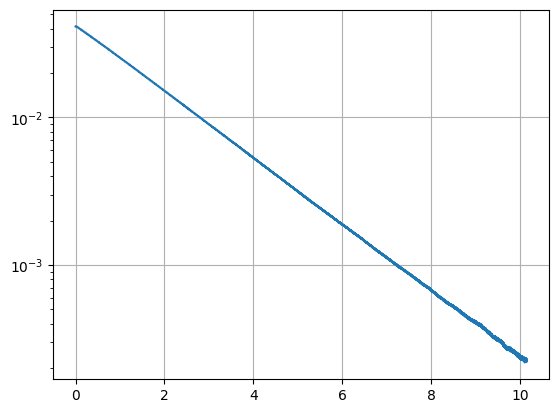

In [36]:
# plot and fit
plt.plot(Data["elapsedtime"], Data["r"], "-")
plt.grid()
plt.yscale("log")

Text(0.5, 1.0, 'Q (w0=153.246kHz): 936394. P=4.0E-6 mbar')

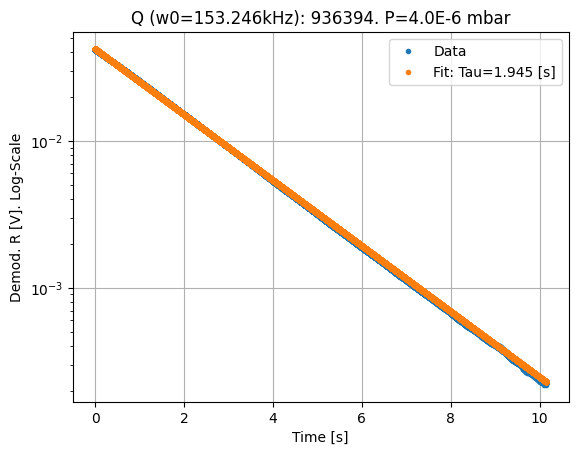

In [38]:
# dir = r"C:\Users\SLAB2\Documents\Zurich Instruments\LabOne\LK_Ringdown"
# f_name = "20250217_LowStressPlainPlotter.txt"
# fp = os.path.join(dir, f_name)

# data = np.loadtxt(fp, comments="%", delimiter=";", skiprows=5)
# data_time = data[:, 0]
# data_signal = data[:, 1]

# data_time_linear = data_time[140:-50]
# data_signal_linear = data_signal[140:-50]

data_time_linear = Data["elapsedtime"]
data_signal_linear = Data["r"]

def exp_fit(input, amp, tau):
    return amp * np.exp(-input / tau)

popt, _ = curve_fit(exp_fit, data_time_linear, data_signal_linear)
data_fit_exp = exp_fit(data_time_linear, *popt)
tau_fit = np.round(popt[1], 3)

freq_resonance = 153.246e3 # kHz
q_factor = freq_resonance * tau_fit * np.pi # Fig. 5.5 VD thesis

plt.plot(data_time_linear, data_signal_linear, ".", label="Data")
plt.plot(data_time_linear, data_fit_exp, ".", label=f"Fit: Tau={tau_fit} [s]")
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Demod. R [V]. Log-Scale")
plt.yscale("log")
plt.legend()
plt.title(f"Q (w0=153.246kHz): {int(np.round(q_factor, 0))}. P=4.0E-6 mbar")

Text(0.5, 0, 'Frequency [Hz]')

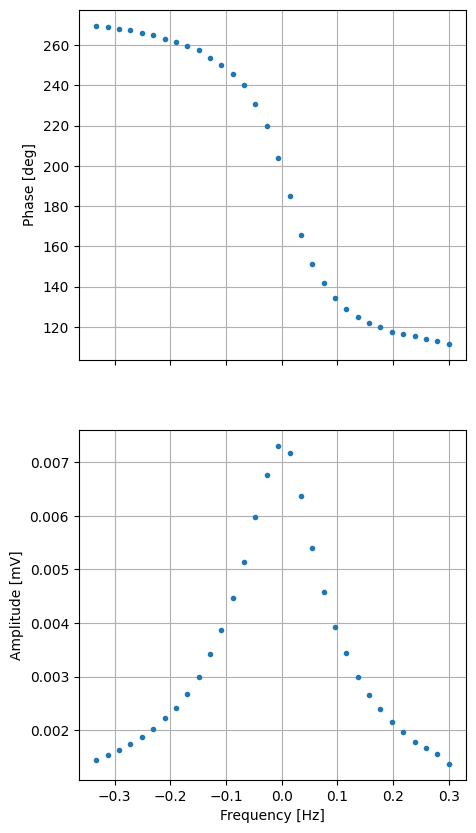

In [111]:
dir = r"C:\Users\SLAB2\Documents\Zurich Instruments\LabOne\LK_Sweep"
f_name = "0603_10dB_AmpPhase_Sweep.txt"
fp = os.path.join(dir, f_name)

data = np.loadtxt(fp, comments="%", delimiter=";", skiprows=7)

ii = 32
offset = 153_290.2 # Hz

frequencies_phase = data[ii:, 0] - offset
signal_phase = data[ii:, 1]

frequencies_amp = data[:ii, 0] - offset
signal_amp = data[:ii, 1]



fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 10), sharex=True)
ax1.plot(frequencies_phase, signal_phase, ".")
ax1.grid()
ax1.set_ylabel("Phase [deg]")
ax2.plot(frequencies_amp, signal_amp, ".")
ax2.grid()
ax2.set_ylabel("Amplitude [mV]")
ax2.set_xlabel("Frequency [Hz]")

-170.0


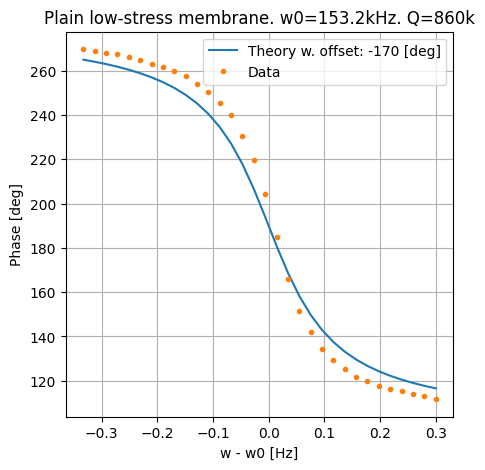

In [147]:
dir = r"C:\Users\SLAB2\Documents\Zurich Instruments\LabOne\LK_Sweep"
f_name = "0603_10dB_AmpPhase_Sweep.txt"
fp = os.path.join(dir, f_name)

data = np.loadtxt(fp, comments="%", delimiter=";", skiprows=7)

ii = 32
resonance = 153_290.2 # Hz
frequencies = data[ii:, 0]
q = 860_000
damp_zeta = 1/(2*q)
initial_offset = 100

def arctan(w, phase0):
    phase0 = phase0 / 180 * np.pi
    return np.arctan2(2*w/resonance*damp_zeta,(w**2/resonance**2-1)) + phase0

out_radian = arctan(frequencies, initial_offset)
out_degree = out_radian * 180 / np.pi

# Fit the data to the Lorentzian function
params, covariance = curve_fit(arctan, frequencies, signal_phase, p0=initial_offset)

# Get the fitted values
fitted_y_data = arctan(frequencies, *params)

fig = plt.figure(figsize=(5, 5))
plt.plot(frequencies-resonance, out_degree, "-", label="Theory w. offset: -170 [deg]")
plt.plot(frequencies-resonance, signal_phase, ".", label="Data")
plt.grid()
plt.legend()
plt.title("Plain low-stress membrane. w0=153.2kHz. Q=860k")
plt.ylabel("Phase [deg]")
plt.xlabel("w - w0 [Hz]")

print(arctan(resonance, initial_offset) * 180/np.pi - 360)

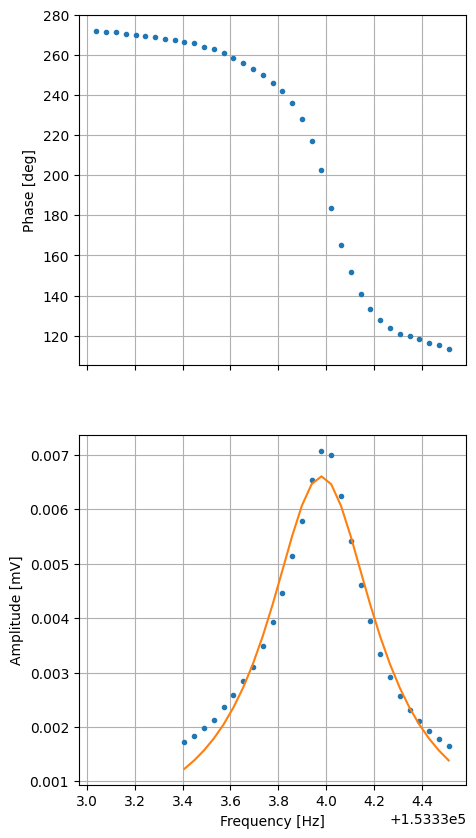

In [28]:
dir = r"C:\Users\SLAB2\Documents\Zurich Instruments\LabOne\LK_Sweep"
f_name = "meas_sweep_20250307_145056.txt"
fp = os.path.join(dir, f_name)

data = np.loadtxt(fp, comments="%", delimiter=";", skiprows=7)

ii = 37
offset = 0 # Hz

frequencies_phase = data[ii:, 0] - offset
signal_phase = data[ii:, 1]

frequencies_amp = data[:ii-9, 0] - offset
signal_amp = data[:ii-9, 1]

def lorentzian(x, x0, gamma, A):
    return A / (1 + ((x - x0) / gamma)**2)


# Initial guess for Lorentzian parameters
initial_guess = [frequencies_amp[len(frequencies_amp)//2], 1, np.max(signal_amp)]  # Guess for x0, gamma, and A

# Fit the data to the Lorentzian function
params, covariance = curve_fit(lorentzian, frequencies_amp, signal_amp, p0=initial_guess)

# Get the fitted values
fitted_y_data = lorentzian(frequencies_amp, *params)
    


fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 10), sharex=True)
ax1.plot(frequencies_phase, signal_phase, ".")
ax1.grid()
ax1.set_ylabel("Phase [deg]")
ax2.plot(frequencies_amp, signal_amp, ".")
ax2.grid()
ax2.set_ylabel("Amplitude [mV]")
ax2.set_xlabel("Frequency [Hz]")
ax2.plot(frequencies_amp, fitted_y_data, label="Fitted Data")
